<a href="https://colab.research.google.com/github/HanaDelport/Projet-NLP/blob/dev/Copie_de_Classification_commentaires_toxiques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importation des packages

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from time import time

# Import Regex to clean up tweets
import re

import nltk, string
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

# Get Reviews
import requests
import json

# Get Tweets
import httplib2
import requests
import urllib3
from drive.MyDrive.RNN_sentiment_dataset.random_tweets import *

# TF IDF Imports


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import csc_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from joblib import dump, load

# RNN & LSTM Imports

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random

random_tweets imported


# Importation des données

Ajoutez un raccourci de ce dossier à votre google drive :

https://drive.google.com/drive/folders/1mx-CAzT10YKrmxHfYDP_1Oef7PVGUr7s?usp=sharing

In [10]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [11]:
data = pd.read_csv('/content/drive/MyDrive/data_classification_commentaires_toxiques/train.csv')
comments = data['comment_text']
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# Etude du jeu de données

In [21]:
# Ajouter une classe "clean_comments"
data['clean_comments'] = 1 - data[data.columns[2:]].max(axis=1)

In [22]:
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate", "clean_comments"]

In [23]:
N = len(data)
label_pct_map = dict()
for label in labels:
    label_pct_map[label] = data[label].sum() / N

[Text(0.5, 1.0, 'Distribution of different classes in the dataset'),
 Text(0.5, 0, 'Toxicity Class'),
 Text(0, 0.5, 'Percentage')]

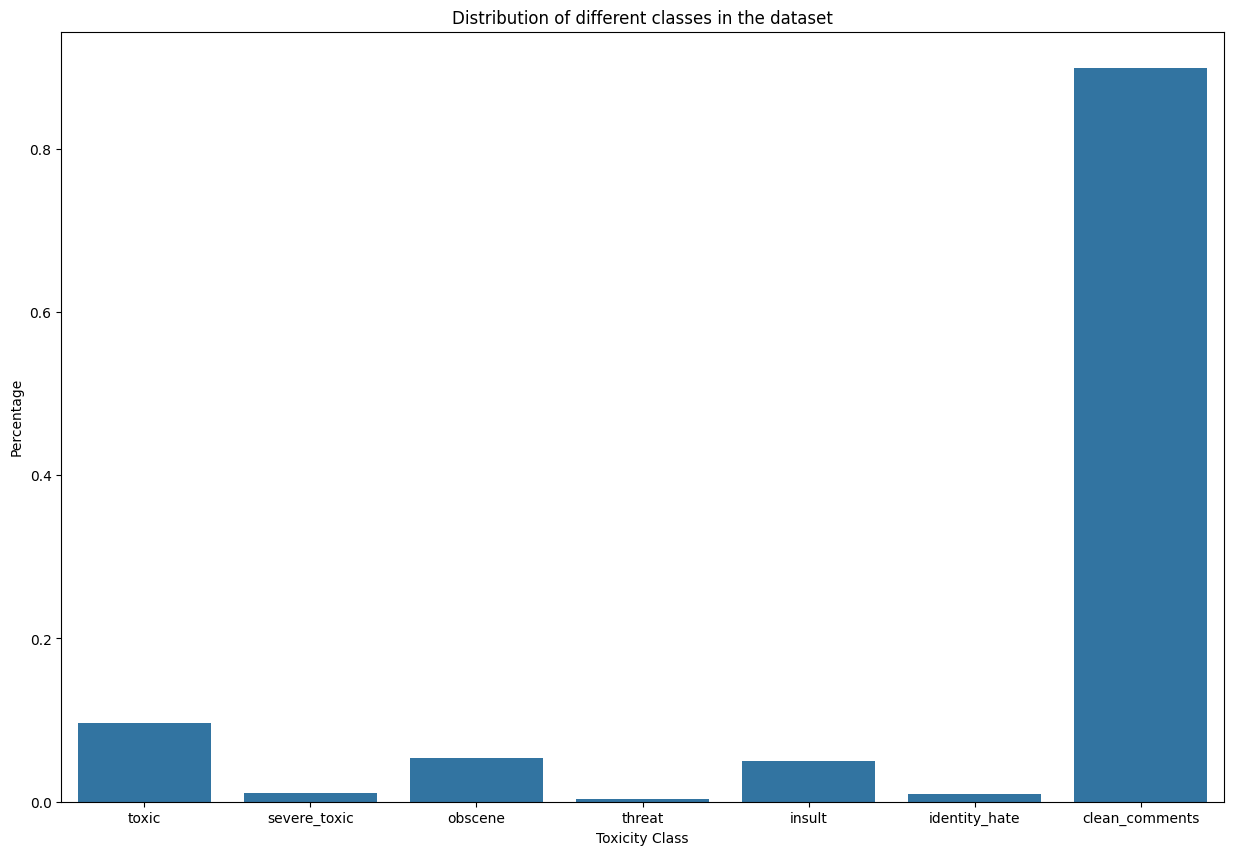

In [24]:
import seaborn as sns

plt.figure(figsize=(15,10))
ax = sns.barplot(x=list(label_pct_map.keys()), y=list(label_pct_map.values()))
ax.set(title="Distribution of different classes in the dataset",
       xlabel="Class",
       ylabel="Percentage")

# Préparation des données

In [73]:
X = data['comment_text']
y = data[data.columns[2:]].values

In [74]:
vectorizer = TextVectorization(max_tokens = max_length, output_sequence_length = 1800, output_mode='int')
vectorizer.adapt(X.values)
vectorizer_text = vectorizer(X.values)

In [83]:
data = tf.data.Dataset.from_generator(lambda: zip(vectorizer_text, y), (tf.string, tf.int32))

data = data.cache()
data = data.shuffle(160000)
data = data.batch(16)
data = data.prefetch(8)

In [126]:
sequences = vectorizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

AttributeError: 'TextVectorization' object has no attribute 'texts_to_sequences'

In [84]:
max_length = 200000

In [108]:
X_serialized = np.array(X_array.tolist())
y_serialized = np.array(y_array.tolist())

data = tf.data.Dataset.from_tensor_slices((X_serialized, y_serialized))

# Taille des ensembles de validation et de test
val_size = int(len(X_array) * 0.2)
test_size = int(len(X_array) * 0.1)

# Taille des ensembles de validation et de test
val_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1)

# Diviser le jeu de données en ensembles d'entraînement, de validation et de test
train_dataset = data.take(len(data) - val_size - test_size)
val_dataset = data.skip(len(data) - val_size - test_size).take(val_size)
test_dataset = data.skip(len(data) - test_size)

# Affichage de la taille de chaque ensemble
print("Taille de l'ensemble d'entraînement:", len(train_dataset))
print("Taille de l'ensemble de validation:", len(val_dataset))
print("Taille de l'ensemble de test:", len(test_dataset))

Taille de l'ensemble d'entraînement: 111700
Taille de l'ensemble de validation: 31914
Taille de l'ensemble de test: 15957


In [117]:
model = Sequential([
    Embedding(max_length + 1, 32, ),
    Bidirectional(LSTM(32, activation='tanh')),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(6, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_7 (Bidirecti  (None, 64)                16640     
 onal)                                                           
                                                                 
 dense_28 (Dense)            (None, 128)               8320      
                                                                 
 dense_29 (Dense)            (None, 256)               33024     
                                                                 
 dense_30 (Dense)            (None, 128)               32896     
                                                                 
 dense_31 (Dense)            (None, 6)                 774       
                                                      

# Entraînement du modèle baseline

In [124]:
train_dataset

<_TakeDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(8,), dtype=tf.string, name=None))>

In [118]:
# Entraîner le modèle
history = model.fit(train_dataset, epochs=5, validation_data=val_dataset)

Epoch 1/5


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_7' (type Sequential).
    
    Input 0 of layer "bidirectional_7" is incompatible with the layer: expected ndim=3, found ndim=1. Full shape received: (32,)
    
    Call arguments received by layer 'sequential_7' (type Sequential):
      • inputs=tf.Tensor(shape=(), dtype=string)
      • training=True
      • mask=None


In [68]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

ValueError: empty vocabulary; perhaps the documents only contain stop words

# Itération de la modélisation

In [ ]:
# Your Code